In [1]:
%load_ext autoreload
%autoreload 2
%load_ext line_profiler
%load_ext memory_profiler

import os
os.environ['KMP_WARNINGS'] = 'off'
import sys
import git

import uproot as ut
import awkward as ak
import numpy as np

import math
import vector
import sympy as sp

import re
from tqdm import tqdm
import timeit
import re


sys.path.append( git.Repo('.', search_parent_directories=True).working_tree_dir )
from utils import *

In [2]:
module = fc.eightb.preselection.ranked_quadh
table.csv = 'ranked_quadh'

signal = ObjIter([Tree(fn) for fn in module.signal_list])
# signal = ObjIter([Tree(module.NMSSM_XYY_YToHH_8b_MX_1000_MY_450)])
# signal_asym = ObjIter([Tree(fc.eightb.preselection.NMSSM_XYY_YToHH_8b_MX_1000_MY_450)])
qcd = ObjIter([Tree(module.QCD_B_List)])
# qcd_asym = ObjIter([Tree(fc.eightb.preselection.QCD_B_List)])
ttbar = ObjIter([Tree(module.TTJets)])
# ttbar = ObjIter([])
# qcd = ObjIter([])

100%|██████████| 2/2 [00:02<00:00,  1.26s/it]


# Event Selection
## - Trigger applied | HLT_PFHT330PT30_QuadPFJet_75_60_45_40_TriplePFBTagDeepCSV_4p5
## - Required at least 8 jets to pass preselection
## - Preselections: Jet $P_{T} > 20$ [GeV], Jet $|\eta| < 2.5$, Tight Jet ID
## - Top 8 Btagged jets selected
## - Jets are paired into di-jets using the QuadHRanker Algorithm
## - Di-Jets are paired into Quad-Jets using by minimizing the mass difference between pairs

In [3]:
bkg = qcd + ttbar
bkg.reweight(2.3)
bkg.set_systematics([0.2])

[None, None]

# MC Reweighting
## MC Background normalization needs to be corrected to match data normalization
## A rough correction of 2.3x is applied along with a 20\% uncertainty

In [4]:
(signal + bkg).apply(lambda t : build_collection(t, 'H\dY\d_b\d', 'jet', ptordered=True))

[None, None, None, None, None]

In [5]:
def ignore(field):
    if not field.startswith('jet_'): return False
    if any( var in field for var in ('signalId','genIdx','higgsIdx','score','genHflag','puid','id','nConstituents') ): return False
    return True

jetvars = [field for field in filter(ignore, signal[0].fields) ]

In [6]:
jetvars

['jet_chEmEF',
 'jet_E',
 'jet_btag',
 'jet_qgl',
 'jet_m',
 'jet_pt',
 'jet_chHEF',
 'jet_eta',
 'jet_ptRegressed',
 'jet_phi',
 'jet_neHEF',
 'jet_neEmEF',
 'jet_mRegressed']

In [7]:
def fix_nConstituents(t):
    nconst = t.jet_nConstituents
    to_big = nconst > 200
    nconst = nconst*(~to_big) + 200 * to_big
    t.extend(
        jet_nConstituents=nconst
    )
(signal+bkg).apply(fix_nConstituents)

[None, None, None, None, None]

In [8]:
bkg.jet_nConstituents

[<Array [[200, 200, 200, 0, ... 36, 15, 22, 18]] type='110692 * var * int64'>, <Array [[28, 23, 28, 30, ... 31, 28, 15, 11]] type='876629 * var * int64'>]

In [13]:
varinfo.jet_nConstituents = dict(bins=(0,100,30))
varinfo.jet_pt = dict()
varinfo.jet_m = dict()
varinfo.jet_btag = dict()
varinfo.jet_qgl = dict(bins=(0,1,30))
varinfo.jet_neEmEF = dict(bins=(0,1,30))
varinfo.jet_neHEF = dict(bins=(0,1,30))
varinfo.jet_chEmEF = dict(bins=(0,1,30))
varinfo.jet_chHEF = dict(bins=(0,1,30))

100%|██████████| 8/8 [00:20<00:00,  2.52s/it]


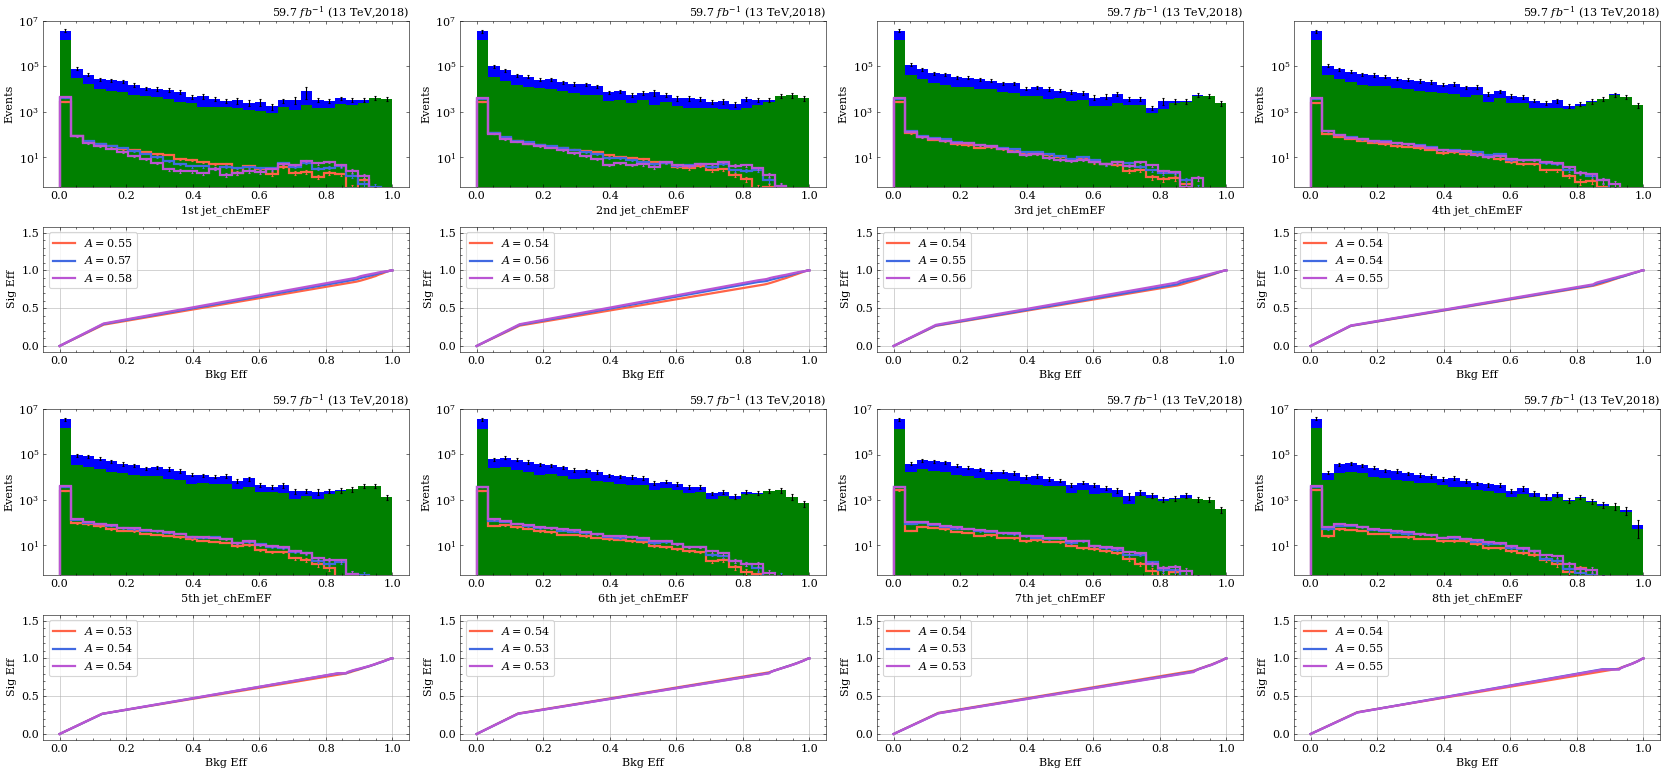

100%|██████████| 8/8 [00:19<00:00,  2.44s/it]


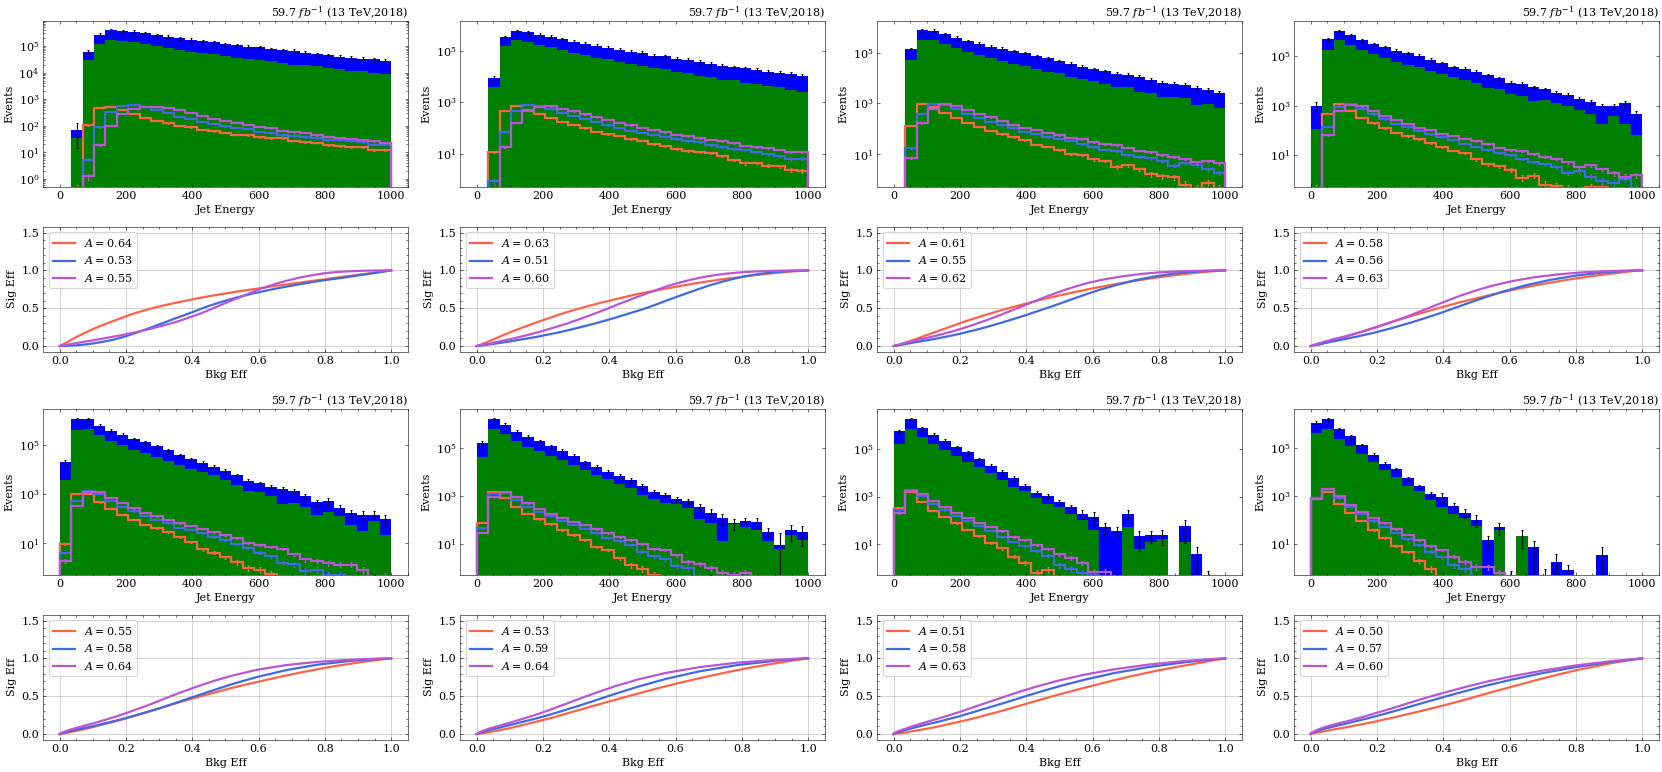

100%|██████████| 8/8 [00:06<00:00,  1.20it/s]


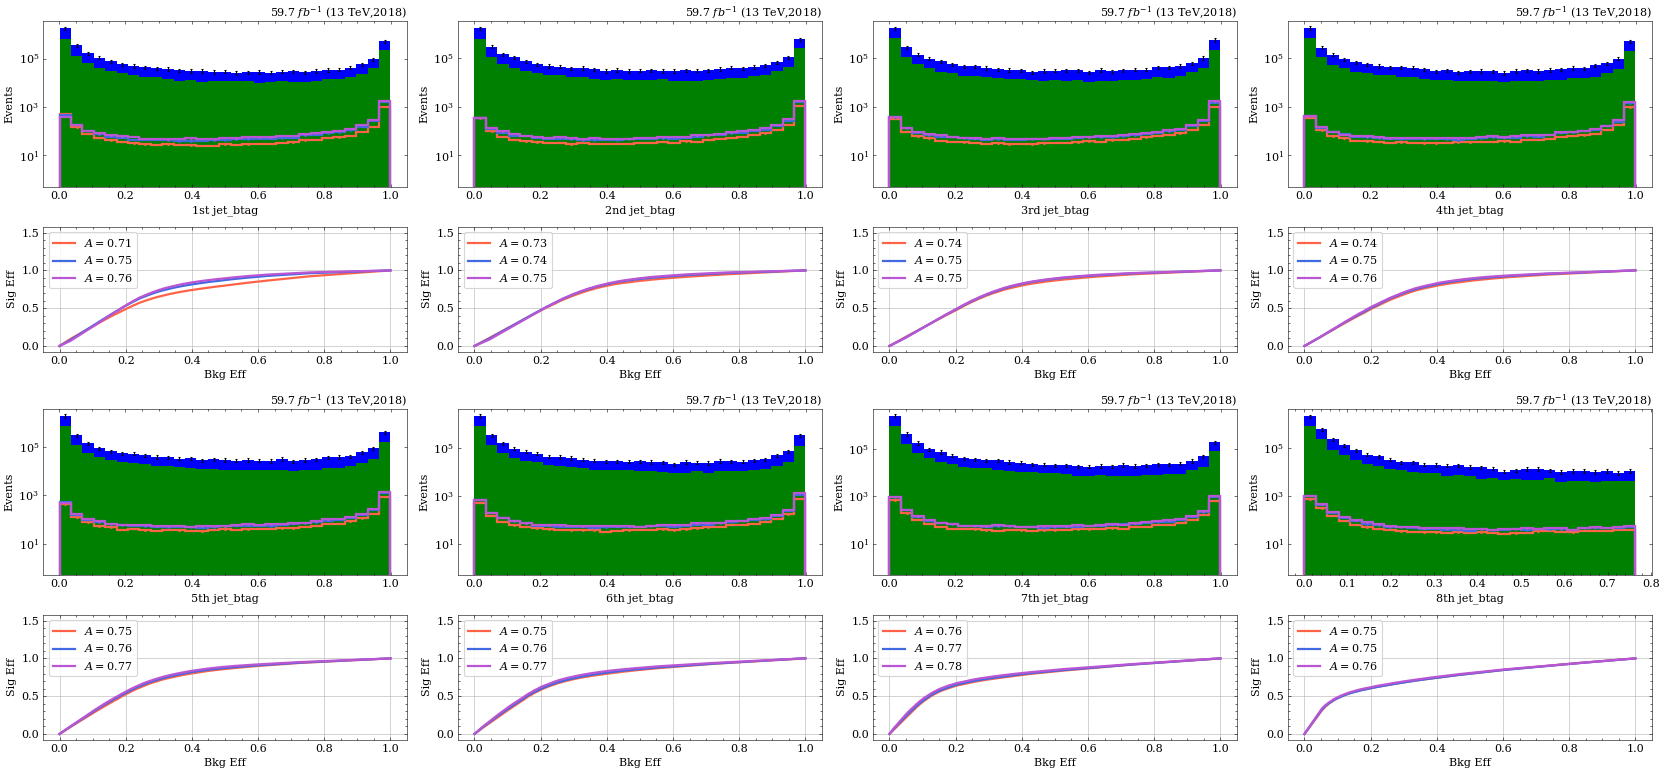

100%|██████████| 8/8 [00:21<00:00,  2.67s/it]


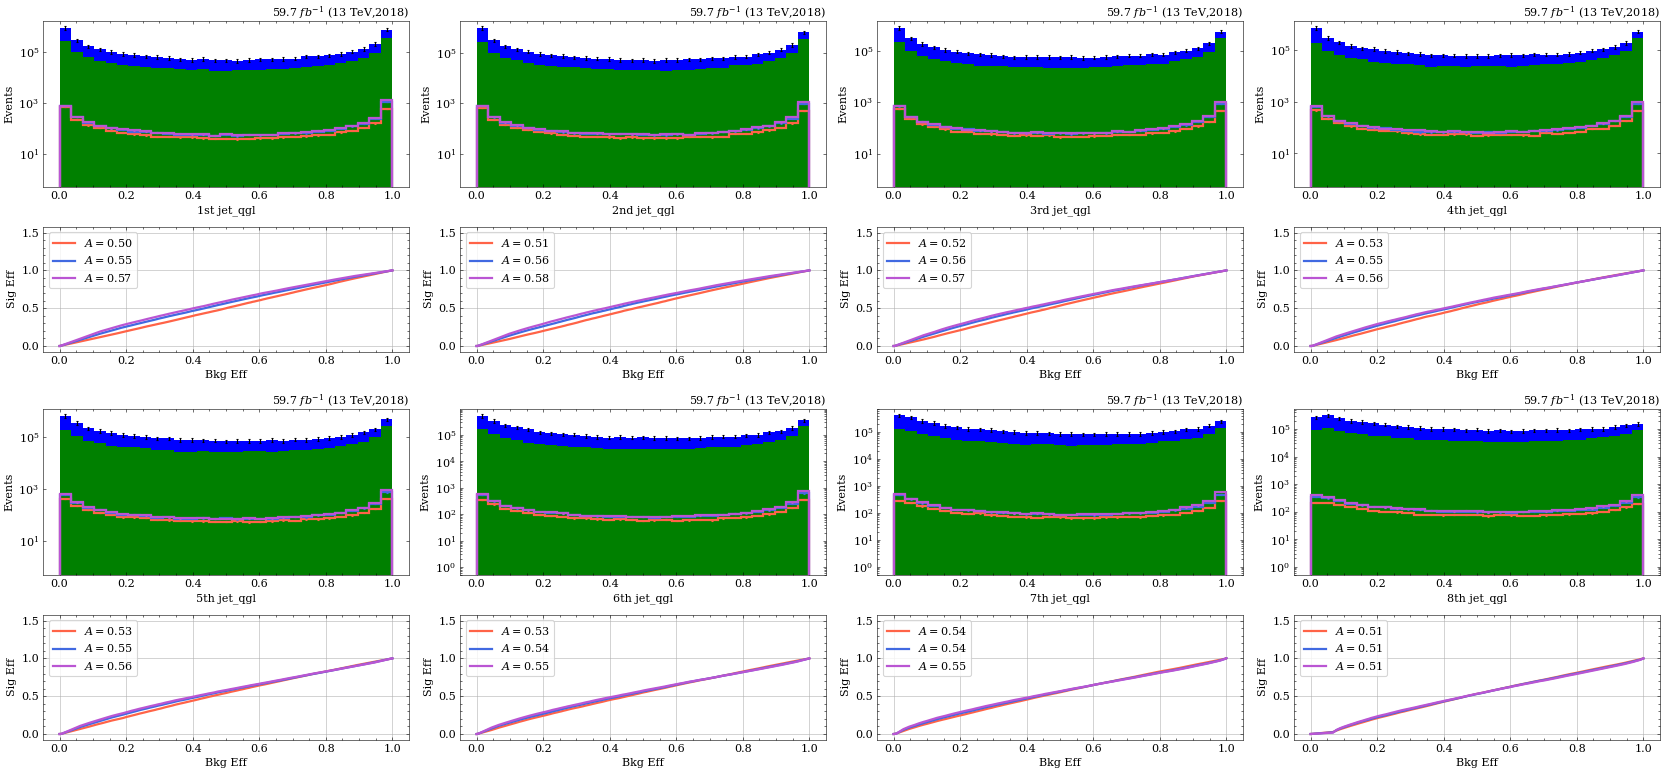

100%|██████████| 8/8 [00:08<00:00,  1.09s/it]


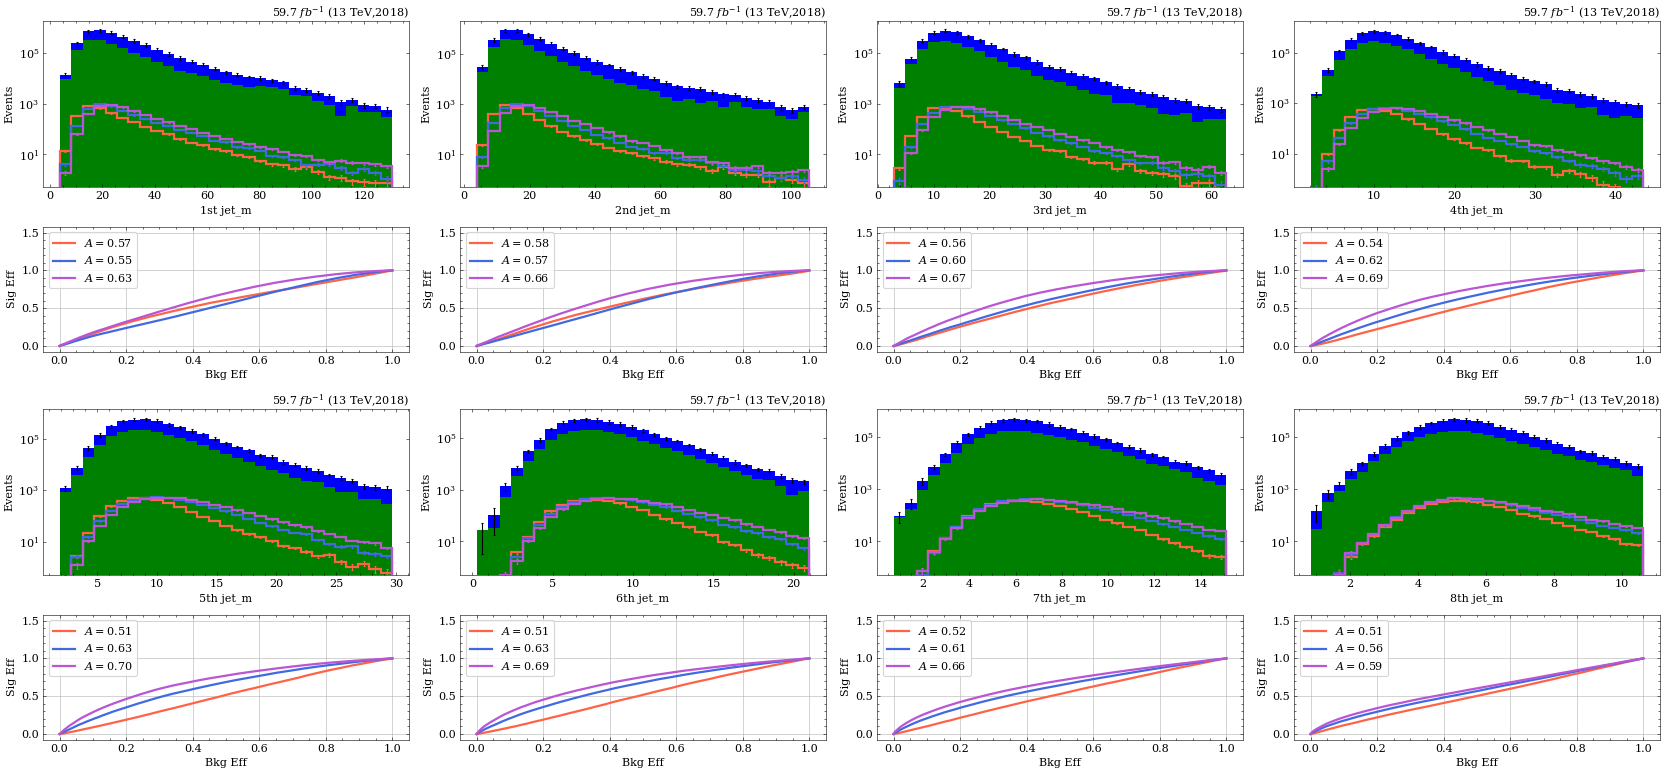

100%|██████████| 8/8 [00:07<00:00,  1.06it/s]


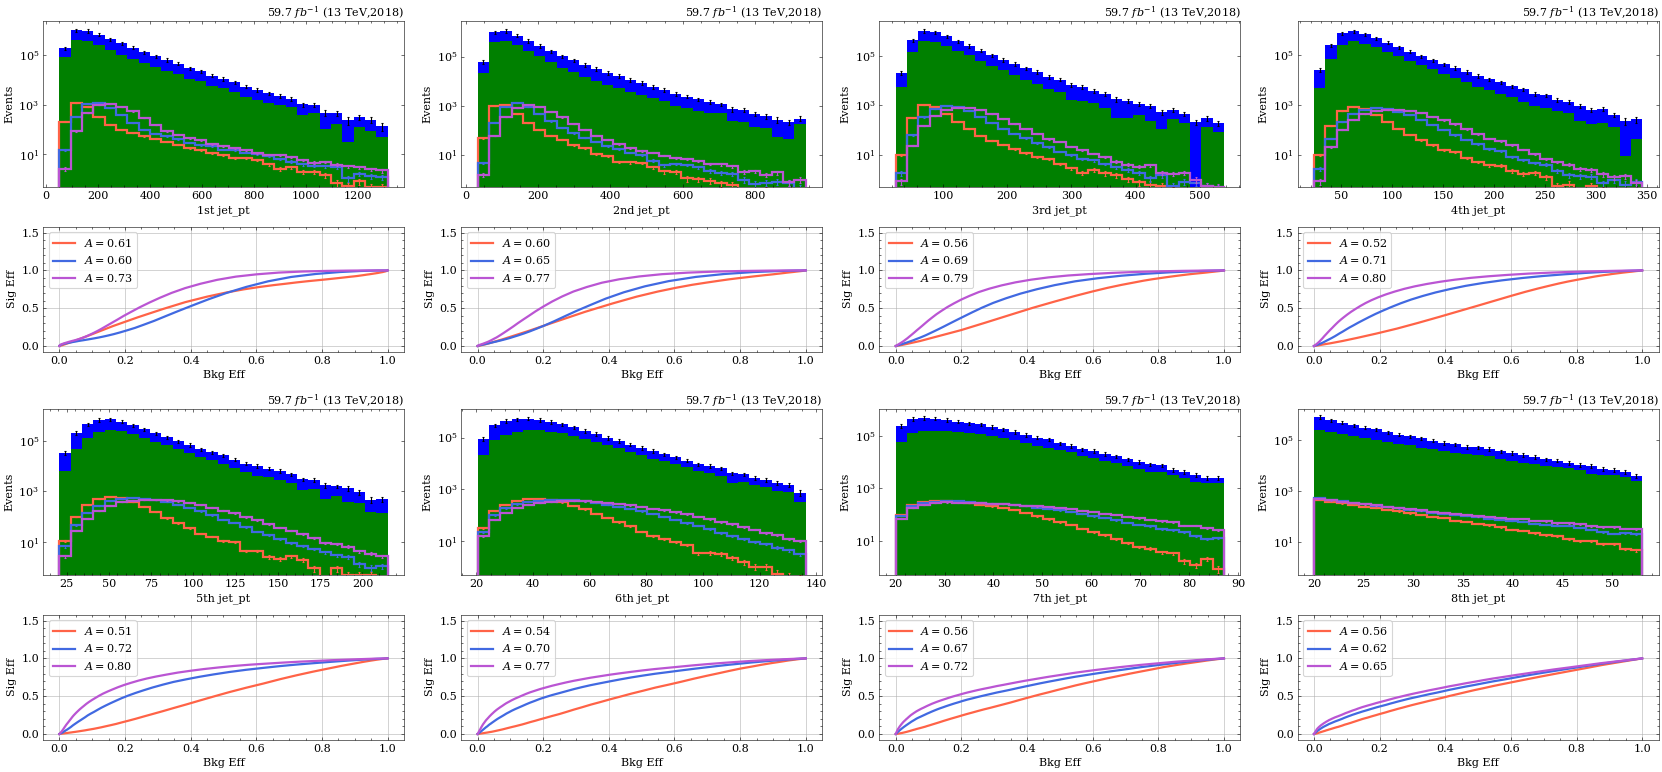

100%|██████████| 8/8 [00:20<00:00,  2.57s/it]


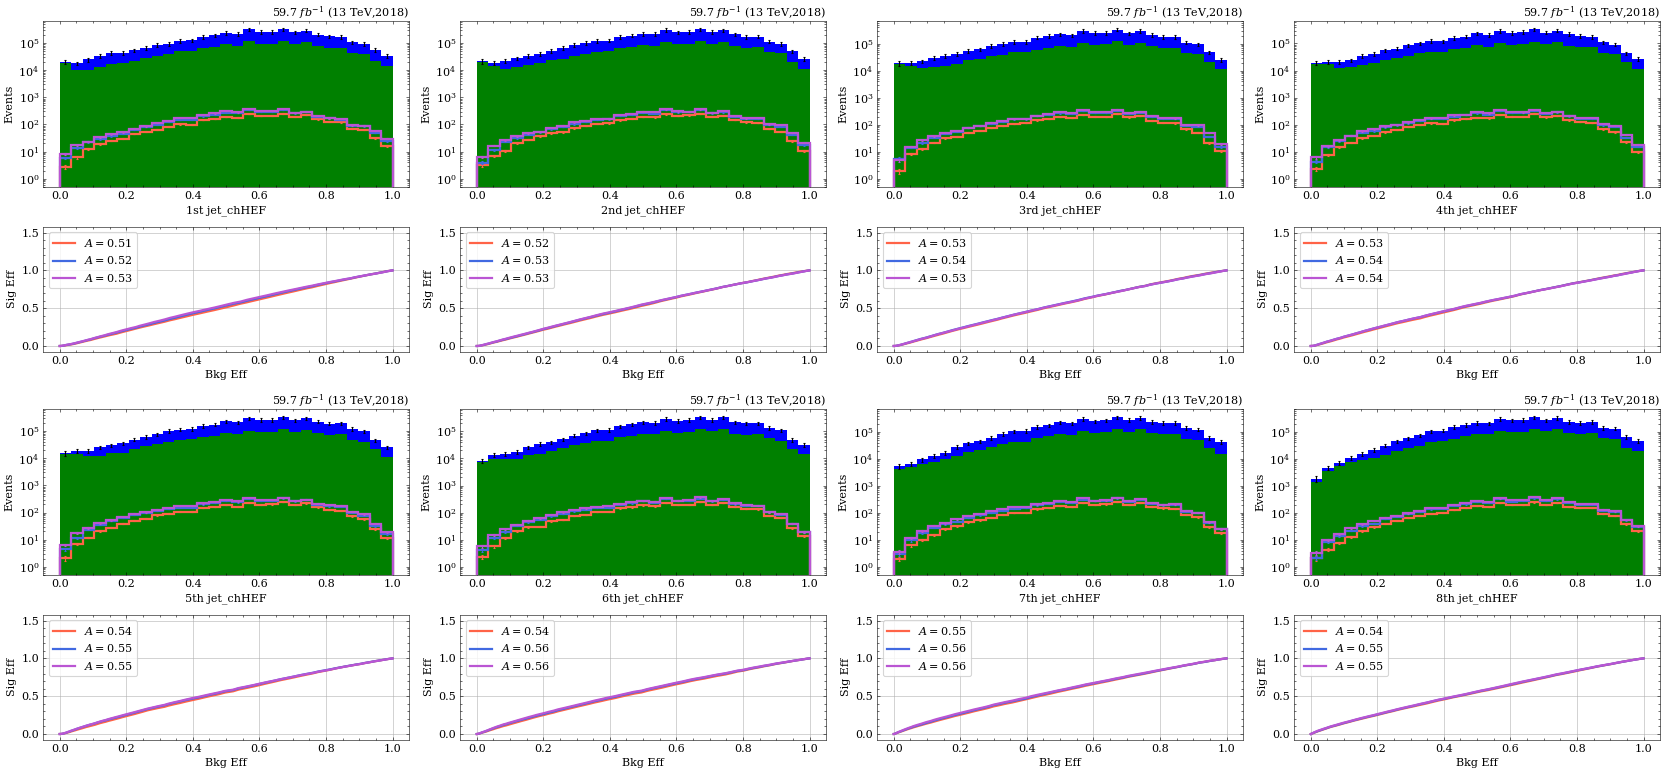

100%|██████████| 8/8 [00:07<00:00,  1.14it/s]


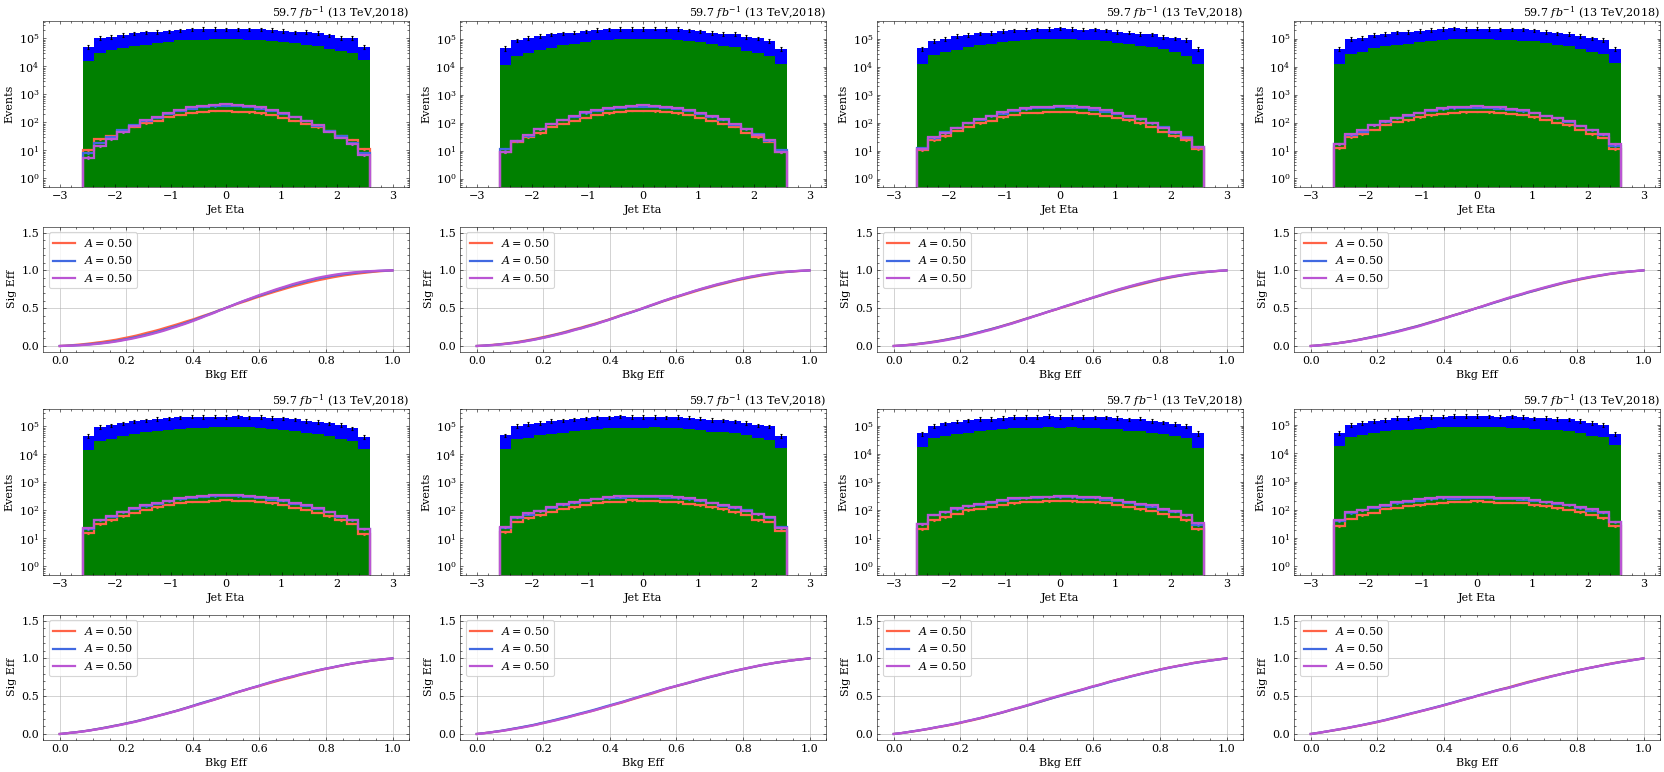

100%|██████████| 8/8 [00:06<00:00,  1.20it/s]


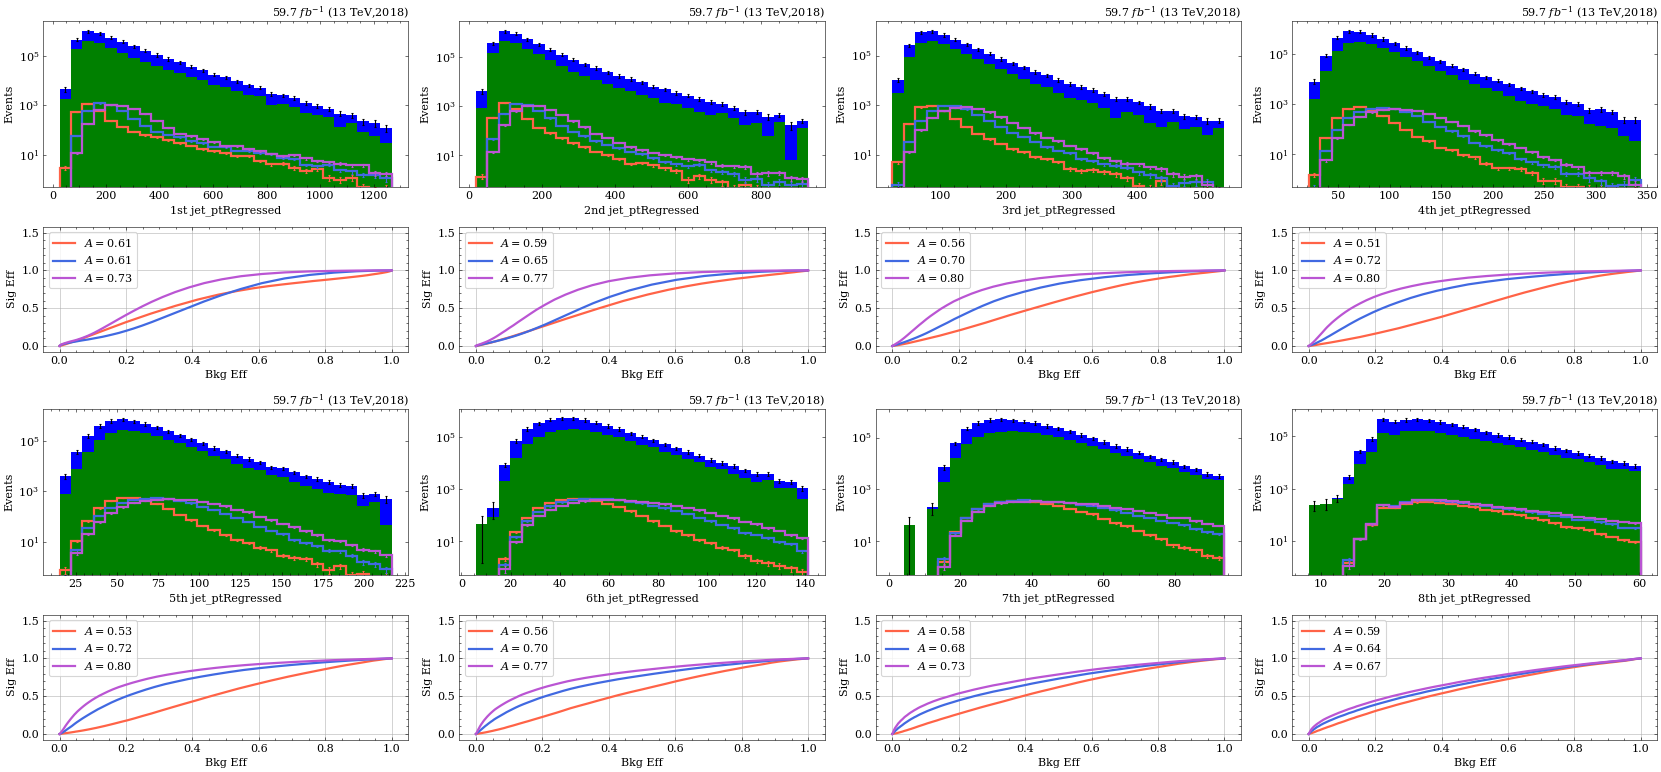

100%|██████████| 8/8 [00:08<00:00,  1.02s/it]


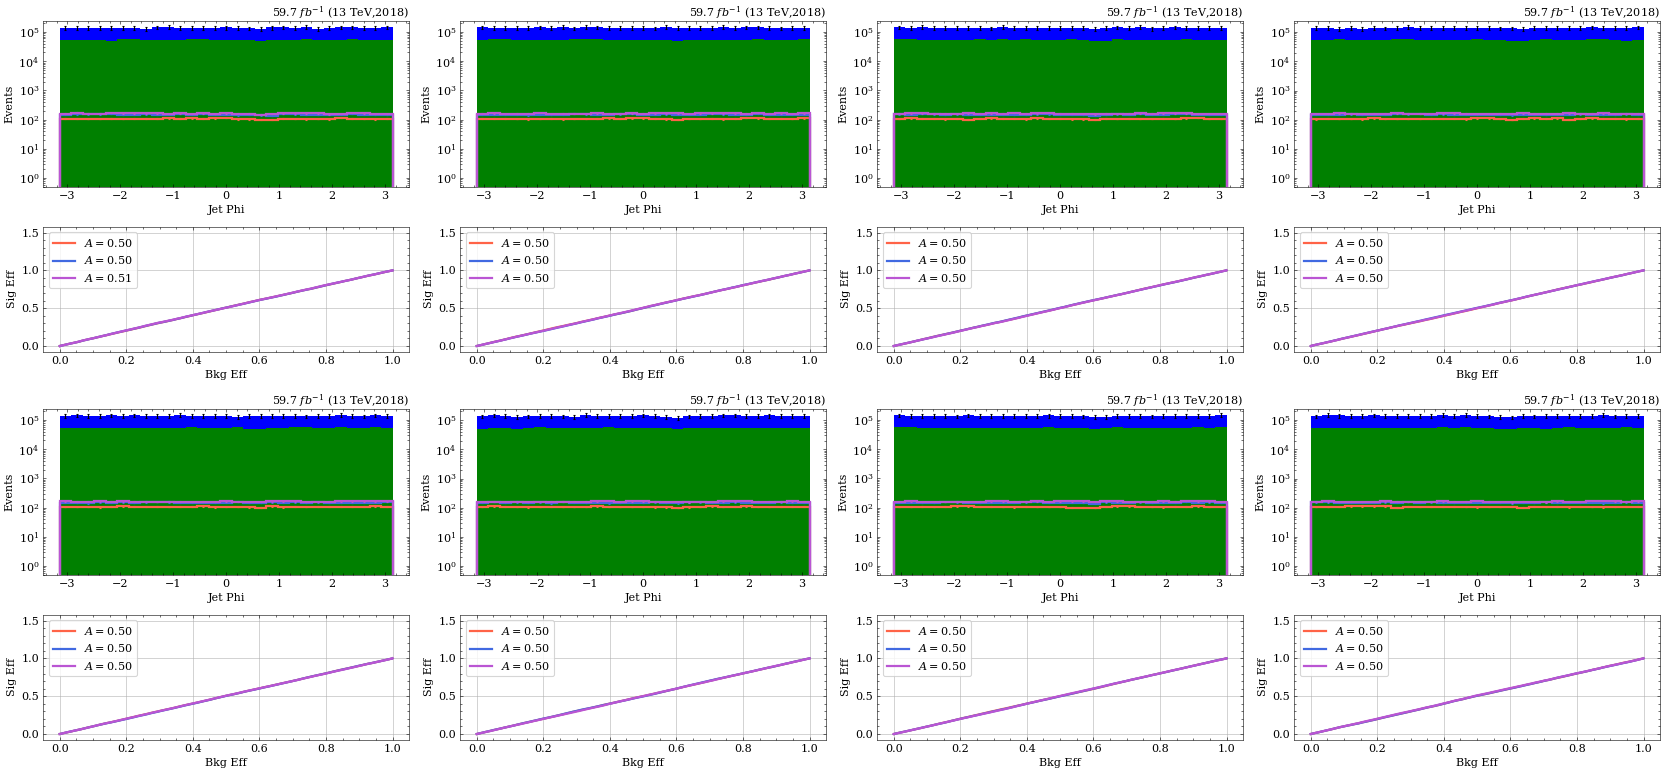

100%|██████████| 8/8 [00:20<00:00,  2.60s/it]


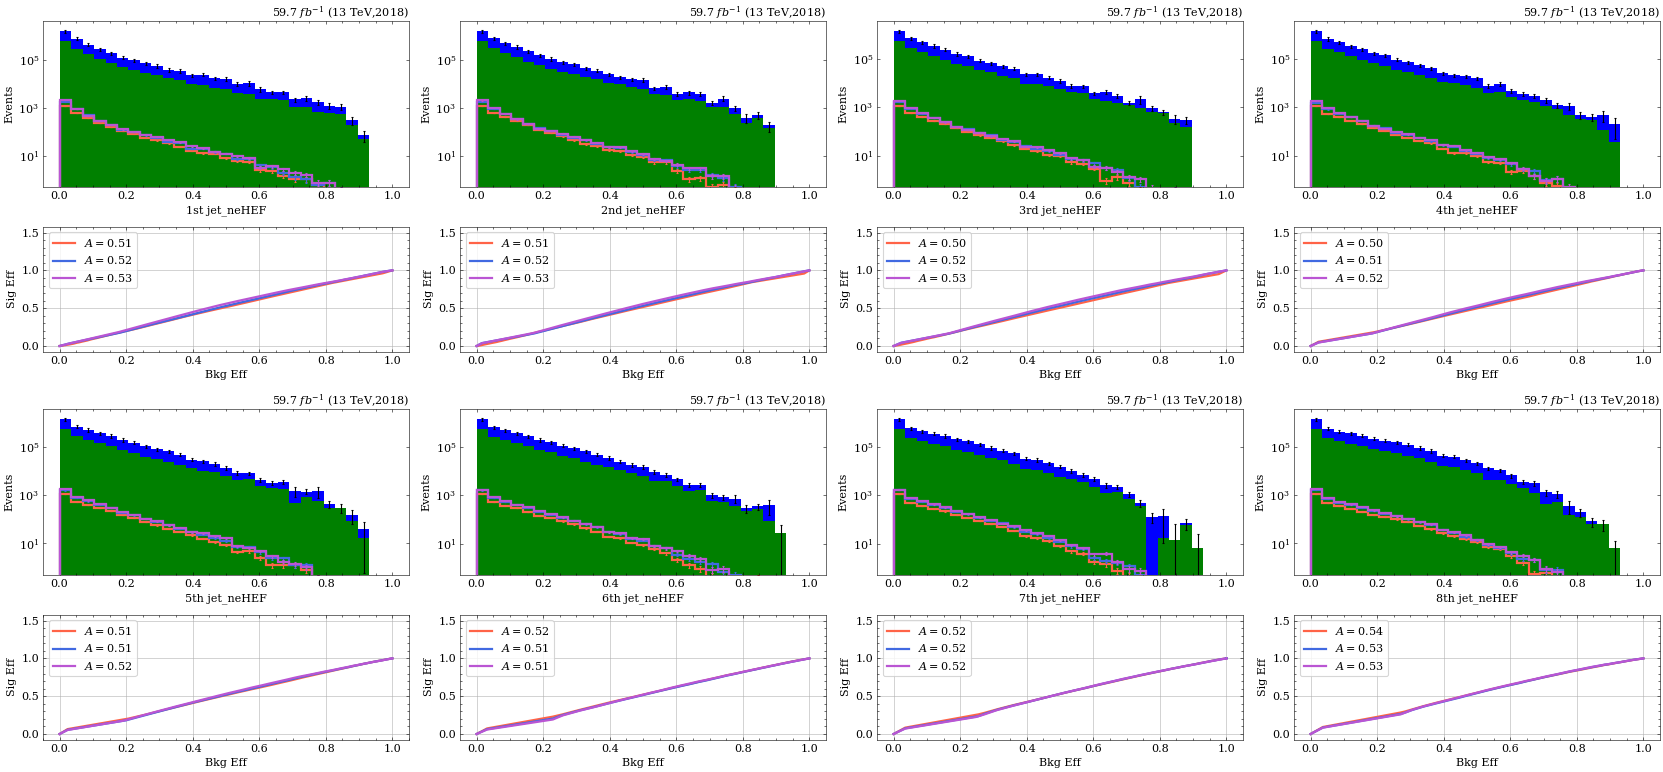

100%|██████████| 8/8 [00:22<00:00,  2.83s/it]


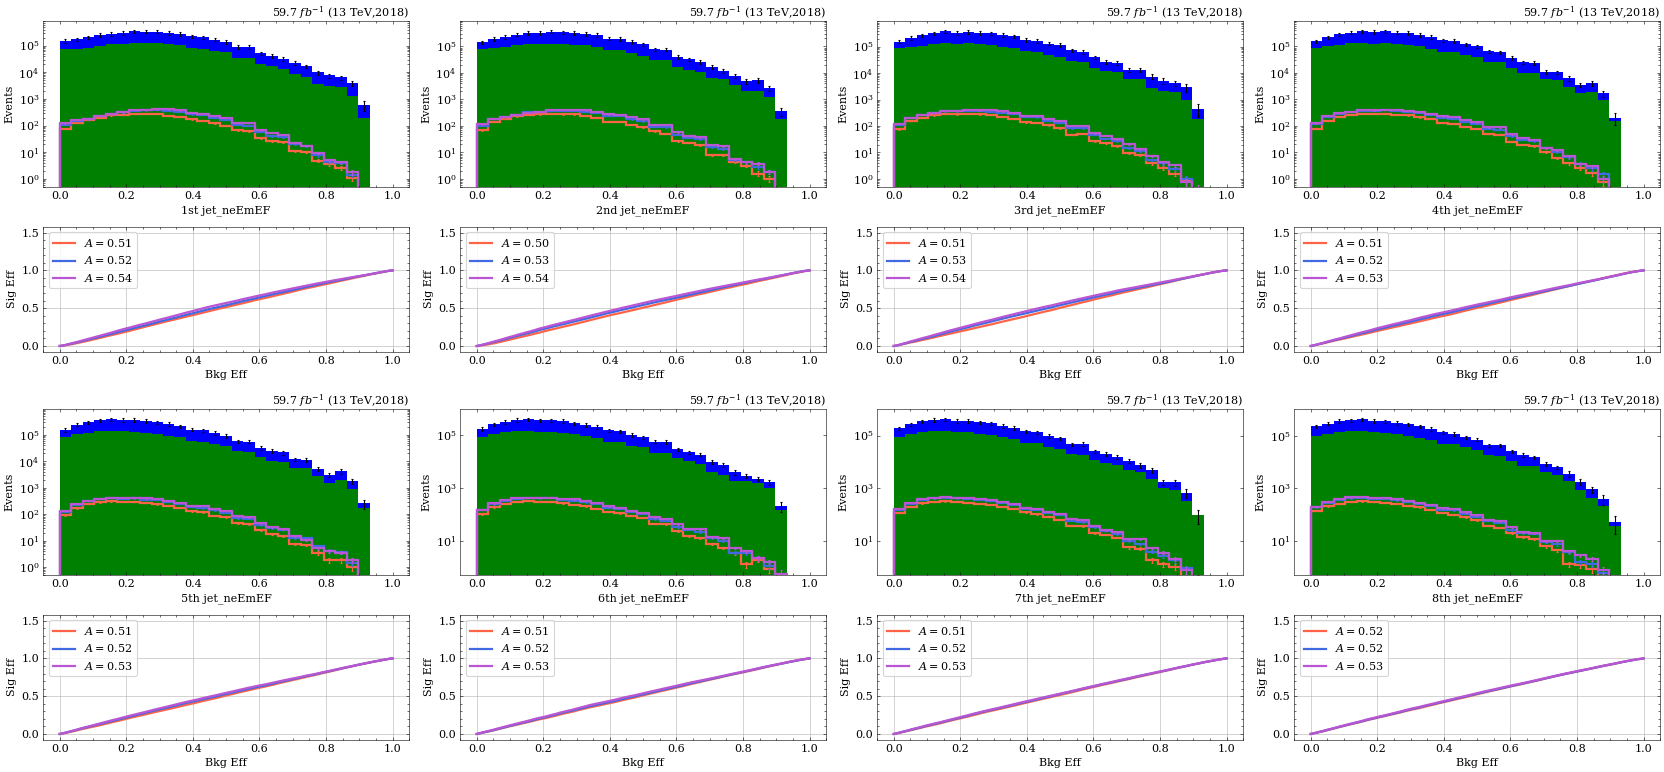

100%|██████████| 8/8 [00:09<00:00,  1.18s/it]


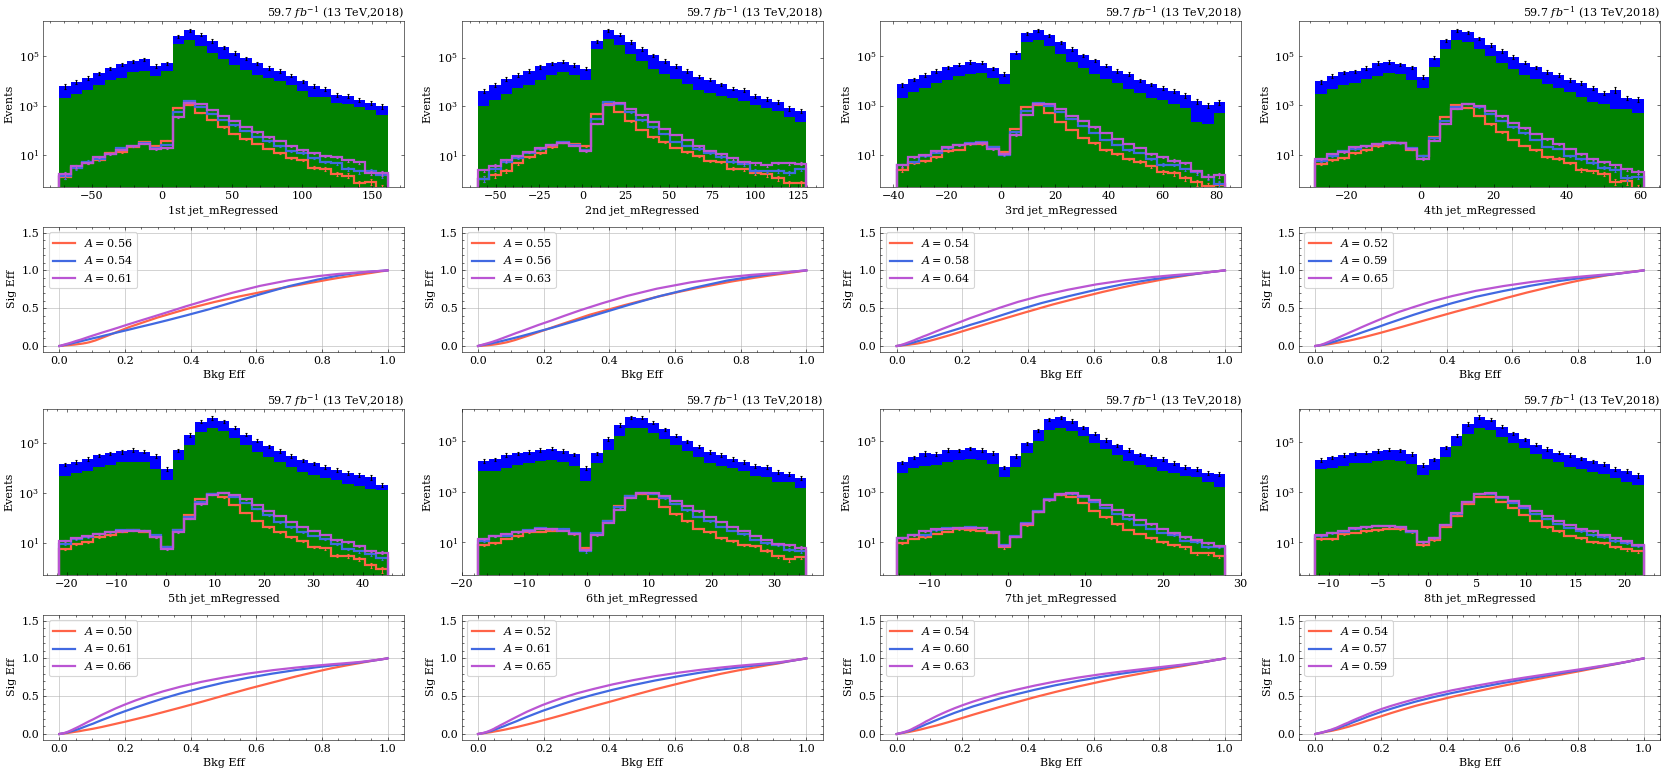

In [16]:
for jetvar in jetvars:

    study.quick(
        signal+bkg,
        varlist=[ f'{jetvar}[:,{i}]' for i in range(8) ],
        # binlist=[np.array(jet_btagWP)]*8,
        log=True, ylim=(0.5e0,-1),
        **study.auroc
    )

    plt.show()

In [15]:
for jetvar in jetvars:
    for i in range(8):
        study.table(
            signal+bkg,
            varlist=[ f'{jetvar}[:,{i}]' ],
            # binlist=[np.array(jet_btagWP)]*8,
            log=True, ylim=(0.5e0,-1),
            **study.auroc,
            e_c_store=obj_store(),
            tablef=table.add_auroc
        )


100%|██████████| 1/1 [00:05<00:00,  5.89s/it]
